#### Check GPU

In [66]:
!nvidia-smi

/bin/bash: /home/djbacad/miniconda3/envs/tensorflow-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon May  8 13:47:25 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.50                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060         On | 00000000:01:00.0  On |                  N/A |
| N/A   73C    P0               41W /  N/A|   5853MiB /  6144MiB |      3%      Default |
|                         

In [67]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Ensure reproducibility by setting global seed

In [68]:
tf.keras.backend.clear_session()
import os
import random as rn
import numpy as np
SEED_VALUE = 888888
os.environ['TF_DETERMINISTIC_OPS'] = str(SEED_VALUE)
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
os.environ["CUDA_VISIBLE_DEVICES"] = str(SEED_VALUE)
rn.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(SEED_VALUE)
tf.config.experimental.enable_op_determinism()

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, 
                                        inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-05-08 13:47:25.780304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 13:47:25.780492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 13:47:25.780541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 13:47:25.781386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 13:47:25.781478: I tensorflow/core/co

#### Import libraries

In [69]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow_addons as tfa
import keras_cv
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### Initialize tunable hyperparameters

In [70]:
EPOCHS = 60
BATCH_SIZE = 16
IMG_SIZE = 224
#Adabelief HPs:
INIT_LEARNING_RATE = 3e-3
TL_EPSILON = 1e-11
TL_WEIGHT_DECAY = 1e-2

#### Load the data and assign the train, val, and test sets

In [71]:
data_loc = '/mnt/e/files_main/projects_ml/guitar-chord-detection/data/Images'

# Train-Val-Test: 65-35-0

# Train
train_set = tf.keras.utils.image_dataset_from_directory(
  directory=data_loc,
  validation_split=0.3,
  subset="training",
  seed=SEED_VALUE,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  shuffle=True
)

# Val
val_set = tf.keras.utils.image_dataset_from_directory(
  directory=data_loc,
  validation_split=0.3,
  subset="validation",
  seed=SEED_VALUE,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  shuffle=True
)

# Test
# Create the test set by breaking down the validation set.
# val_batches = tf.data.experimental.cardinality(val_set)
# val_set = val_set.skip((2*val_batches) // 3)
# test_set = val_set.take((2*val_batches) // 3)

Found 166 files belonging to 3 classes.
Using 117 files for training.
Found 166 files belonging to 3 classes.
Using 49 files for validation.


In [72]:
class_names = np.array(train_set.class_names)
print(class_names)

['C' 'D' 'G']


In [73]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2023-05-08 13:47:27.355785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [117]
	 [[{{node Placeholder/_4}}]]
2023-05-08 13:47:27.356394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [117]
	 [[{{node Placeholder/_4}}]]


(16, 224, 224, 3)
(16,)


#### Use buffered prefetching for performance

In [74]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.prefetch(buffer_size=AUTOTUNE)
val_set = val_set.prefetch(buffer_size=AUTOTUNE)
#test_set = test_set.prefetch(buffer_size=AUTOTUNE)

#### Define the on-the-fly data augmentation steps

In [75]:
data_augmentation = tf.keras.Sequential([
  layers.RandomTranslation(0.15,0.15),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.3),
  layers.RandomBrightness(factor=0.15),
  keras_cv.layers.RandomShear(0.15,0.12)
])

#### Create the base model

In [76]:
base_model = EfficientNetV2B0(weights='imagenet',
                              include_top=False, 
                              pooling='avg',
                              input_shape=(IMG_SIZE, IMG_SIZE, 3)) 


# Freeze
base_model.trainable = False
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0

#### Attach the new top layers / classification head

In [77]:
# global_average_layer = GlobalAveragePooling2D()
# prediction_layer = Dense(3)

# inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x) #Specific preprocess_input from EfficientNetV2B0 keras application
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x,training=False)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x,training=False)
# x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)

2023-05-08 13:47:34.191574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice}}]]
2023-05-08 13:47:34.230734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform_1/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/tra

2023-05-08 13:47:34.914263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-08 13:47:34.946873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform_1/strided_slice' wi

#### Compile the model

In [78]:
# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.15)
    
# lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

optim = tfa.optimizers.AdaBelief(learning_rate=INIT_LEARNING_RATE,
                                 weight_decay=TL_WEIGHT_DECAY,
                                 epsilon=TL_EPSILON)

model.compile(optimizer=optim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

# efficientnetb0_transfer_model.compile(optimizer = optim, 
#                           loss = 'categorical_crossentropy', 
#                           metrics=['accuracy'])

In [79]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5,923,155
Trainable params: 3,843
Non-trainable params: 5,919,312
_______________________________________________

In [80]:
history = model.fit(train_set,
                    epochs=100,
                    validation_data=val_set,
                    #callbacks = [lr_scheduler],
                    )

Epoch 1/100


2023-05-08 13:47:36.192999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [117]
	 [[{{node Placeholder/_4}}]]
2023-05-08 13:47:36.193504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [117]
	 [[{{node Placeholder/_0}}]]


2023-05-08 13:47:36.940127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-08 13:47:36.981392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loo

2023-05-08 13:47:40.972141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-08 13:47:41.011607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loo

8/8 [==============================] - ETA: 0s - loss: 1.2201 - acc: 0.3248

2023-05-08 13:47:46.933879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [49]
	 [[{{node Placeholder/_4}}]]
2023-05-08 13:47:46.934774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [49]
	 [[{{node Placeholder/_4}}]]


8/8 [==============================] - 13s 445ms/step - loss: 1.2201 - acc: 0.3248 - val_loss: 1.1413 - val_acc: 0.4286
Epoch 2/100
8/8 [==============================] - 1s 109ms/step - loss: 1.2102 - acc: 0.3419 - val_loss: 1.1359 - val_acc: 0.4490
Epoch 3/100
8/8 [==============================] - 1s 132ms/step - loss: 1.1993 - acc: 0.3761 - val_loss: 1.1318 - val_acc: 0.4694
Epoch 4/100
8/8 [==============================] - 1s 106ms/step - loss: 1.1355 - acc: 0.4444 - val_loss: 1.1205 - val_acc: 0.4490
Epoch 5/100
8/8 [==============================] - 1s 115ms/step - loss: 1.2677 - acc: 0.3932 - val_loss: 1.1060 - val_acc: 0.4490
Epoch 6/100
8/8 [==============================] - 1s 105ms/step - loss: 1.0844 - acc: 0.4359 - val_loss: 1.0700 - val_acc: 0.4694
Epoch 7/100
8/8 [==============================] - 1s 104ms/step - loss: 1.0750 - acc: 0.4615 - val_loss: 1.0547 - val_acc: 0.4490
Epoch 8/100
8/8 [==============================] - 1s 101ms/step - loss: 1.0947 - acc: 0.3675 

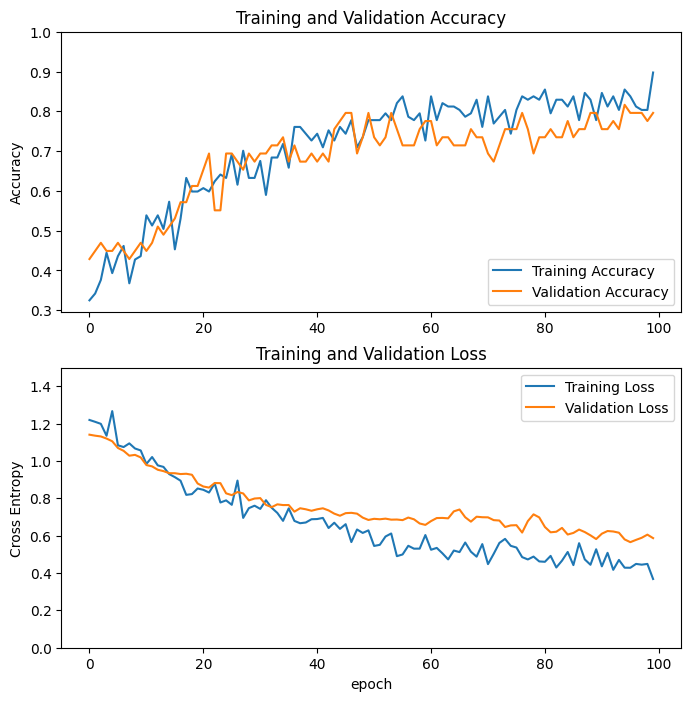

In [81]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [85]:
# Latest EfficientNet architecture
# Feature vectors of images with input size 240x240, trained on imagenet-21k
efficientnet_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2"
feature_extractor = efficientnet_v2

In [86]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor,
    input_shape=(IMG_SIZE_V1, IMG_SIZE_V1, 3),
    trainable=False) #Freeze so that training happens only on the top layer.

In [92]:
feature_extractor_layer

In [91]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

ValueError: Exception encountered when calling layer 'keras_layer' (type KerasLayer).

Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * <tf.Tensor 'inputs:0' shape=(32, 240, 240, 1) dtype=float32>
    * False
    * False
  Keyword arguments: {}

 Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1')
    * False
    * False
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
    * False
    * False
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
    * True
    * False
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1')
    * True
    * False
  Keyword arguments: {}

Call arguments received by layer 'keras_layer' (type KerasLayer):
  • inputs=tf.Tensor(shape=(32, 240, 240, 1), dtype=float32)
  • training=None

#### Attach the top layer / classification head

In [89]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])


In [90]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.